In [1]:
cd ..

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing


In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads'
os.environ['HF_DATASETS_CACHE'] = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads'
os.environ['TRANSFORMERS_OFFLINE'] = '1'

In [7]:
import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import spacy_alignments as tokenizations
import numpy as np
import pandas as pd
import seaborn as sns
from transformer_lens.utils import gelu_fast
import math
import torch
from probing_datasets.ewt import *
from activations.activation_all import load_activation_all
from circuitsvis.tokens import colored_tokens
import einops
from activations.activation_subset import load_activation_subset

from load import *

from analysis.load_results import (
    load_probing_experiment_results, 
    make_heuristic_probing_results_df,
    collect_monosemantic_results
)

%load_ext autoreload
%autoreload 2


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
model = load_model('pythia-70m')
decoded_vocab = {v: model.to_string(v) for k, v in model.tokenizer.get_vocab().items()}
idecoded_vocab = {v: k for k, v in decoded_vocab.items()}

No pythia-70m-v0 available


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m into HookedTransformer


In [5]:
ds = load_feature_dataset('compound_words.pyth.24.-1')


/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [14]:
results_dir = 'results'
experiment_name = 'compound_superposition_final'
model_name = 'pythia-1b'
dataset_name = 'compound_words.pyth.24.-1'
inner_loop = 'iterative_pruning_rotation_baseline_dxd'

probing_results, metadata = load_probing_experiment_results(results_dir, experiment_name, model_name, dataset_name, inner_loop, uncollapse_features=True)


In [36]:
def collect_iterative_pruning_vs_baseline_results(probing_results):
    dfs = {}
    for k, result in probing_results.items():
        dfs[k] = pd.DataFrame(result['nominal']).T
    rdf = pd.concat(dfs)#.reset_index()
    rdf.rename_axis(
        index=['feature', 'layer', 'aggregation', 'hook_loc', 'nueron'],
        inplace=True
    )
    rdf['trial'] = 'nominal'
    baseline_dfs = {}
    for k, result in probing_results.items():
        for trial, trial_result in result['baseline'].items():
            df = pd.DataFrame(trial_result).T
            #df['trial'] = trial
            baseline_dfs[k + (trial, )] = df

    brdf = pd.concat(baseline_dfs)
    brdf.rename_axis(
        index=['feature', 'layer', 'aggregation', 'hook_loc', 'trial', 'nueron'],
        inplace=True
    )
    return rdf.sort_index(), brdf.sort_index()

In [48]:
rdf, brdf = collect_iterative_pruning_vs_baseline_results(probing_results)

In [28]:
brdf.sort_values('test_mcc', ascending=False).head(10)

test_mcc  \
feature       layer aggregation hook_loc      nueron trial             
prime-factors 1     none        mlp.hook_post 1      3523   0.975156   
                                              3      6207    0.96759   
                                              2      3672   0.961226   
              3     none        mlp.hook_post 4      2701   0.956303   
              2     none        mlp.hook_post 0      1485   0.955263   
              5     none        mlp.hook_post 2      271    0.950226   
              1     none        mlp.hook_post 2      6576   0.948029   
                                              3      3785   0.946835   
                                              0      3399   0.946007   
                                              2      4357   0.945424   

                                                           test_cohen_kappa  \
feature       layer aggregation hook_loc      nueron trial                    
prime-factors 1     none        mlp.hook_post 1      3523          0.974847   
                                              3      6207          0.967066   
                                              2      3672          0.960575   
              3     none        mlp.hook_post 4      2701          0.955462   
              2     none        mlp.hook_post 0      1485          0.954263   
              5     none        mlp.hook_post 2      271           0.949118   
              1     none        mlp.hook_post 2      6576          0.946681   
                                              3      3785          0.945424   
                                              0      3399          0.945072   
                                              2      4357           0.94408   

                                                            test_fmi  \
feature       layer aggregation hook_loc      nueron trial             
prime-factors 1     none        mlp.hook_post 1      3523   0.979966   
                                              3      6207   0.973886   
                                              2      3672   0.968777   
              3     none        mlp.hook_post 4      2701   0.964831   
              2     none        mlp.hook_post 0      1485   0.963998   
              5     none        mlp.hook_post 2      271    0.959965   
              1     none        mlp.hook_post 2      6576   0.958209   
                                              3      3785   0.957254   
                                              0      3399   0.956583   
                                              2      4357   0.956126   

                                                           test_f1_score  \
feature       layer aggregation hook_loc      nueron trial                 
prime-factors 1     none        mlp.hook_post 1      3523       0.979766   
                                              3      6207       0.973545   
                                              2      3672       0.968354   
              3     none        mlp.hook_post 4      2701       0.964286   
              2     none        mlp.hook_post 0      1485       0.963351   
              5     none        mlp.hook_post 2      271        0.959248   
              1     none        mlp.hook_post 2      6576       0.957336   
                                              3      3785       0.956341   
                                              0      3399       0.955975   
                                              2      4357       0.955255   

                                                           test_f0.5_score  \
feature       layer aggregation hook_loc      nueron trial                   
prime-factors 1     none        mlp.hook_post 1      3523         0.968013   
                                              3      6207         0.958333   
                                              2      3672         0.951493   
              3     none        mlp.hook_post 4      2701         0.945222   


In [32]:
import matplotlib as mpl

def colorFader(c1='red', c2='blue', mix=0):
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def plot_top_neurons(monosemantic_results_df, metric='test_f1_score'):
    features = monosemantic_results_df.index.get_level_values('feature').unique().values
    layers = sorted(monosemantic_results_df.index.get_level_values('layer').unique())
    n_rows = math.ceil(len(features) / 3)
    fig, axs = plt.subplots(n_rows, 3, figsize=(10, 3 * n_rows), sharex=True, sharey=True)
    for ix, f in enumerate(features):
        for l in layers:
            ax = axs[ix // 3, ix % 3]
            sub_df = monosemantic_results_df.query('feature==@f and layer==@l')
            neuron_prs = np.sort(sub_df[metric].values)[::-1]
            ax.plot(neuron_prs, label=l, color=colorFader(mix=l/len(layers)))
        ax.set_title(f)
        ax.legend(title='layer', loc='lower left', ncol=3, prop={'size': 6})
        # dotted black horizontal line at 1.0
        ax.axhline(1.0, color='black', linestyle='dotted', alpha=0.5)
        if ix % 3 == 0:
            ax.set_ylabel(metric)
        if ix >= len(features) - 3:
            ax.set_xlabel('neuron')
    plt.tight_layout()

In [53]:
brdf.loc[:, 'neuron_rank'] = brdf.groupby(['feature', 'layer', 'trial'])['test_f1_score'].rank(ascending=False, method='first')
# for name, group in brdf.groupby(['feature', 'layer', 'trial']):
#     group.loc[:, 'neuron_ranking'] = group['test_f1_score'].rank(ascending=False)
avg_baseline = pd.DataFrame(brdf.groupby(['feature', 'layer', 'neuron_rank'])['test_f1_score'].mean())

In [52]:
pd.DataFrame(avg_baseline)

test_f1_score
feature        layer neuron_rank               
blood-pressure 0     1.0               0.515530
                     2.0               0.513961
                     3.0               0.512348
                     4.0               0.512060
                     5.0               0.510801
...                                         ...
trial-court    15    96.0              0.403278
                     97.0              0.401831
                     98.0              0.397823
                     99.0              0.392137
                     100.0             0.383545

[33600 rows x 1 columns]

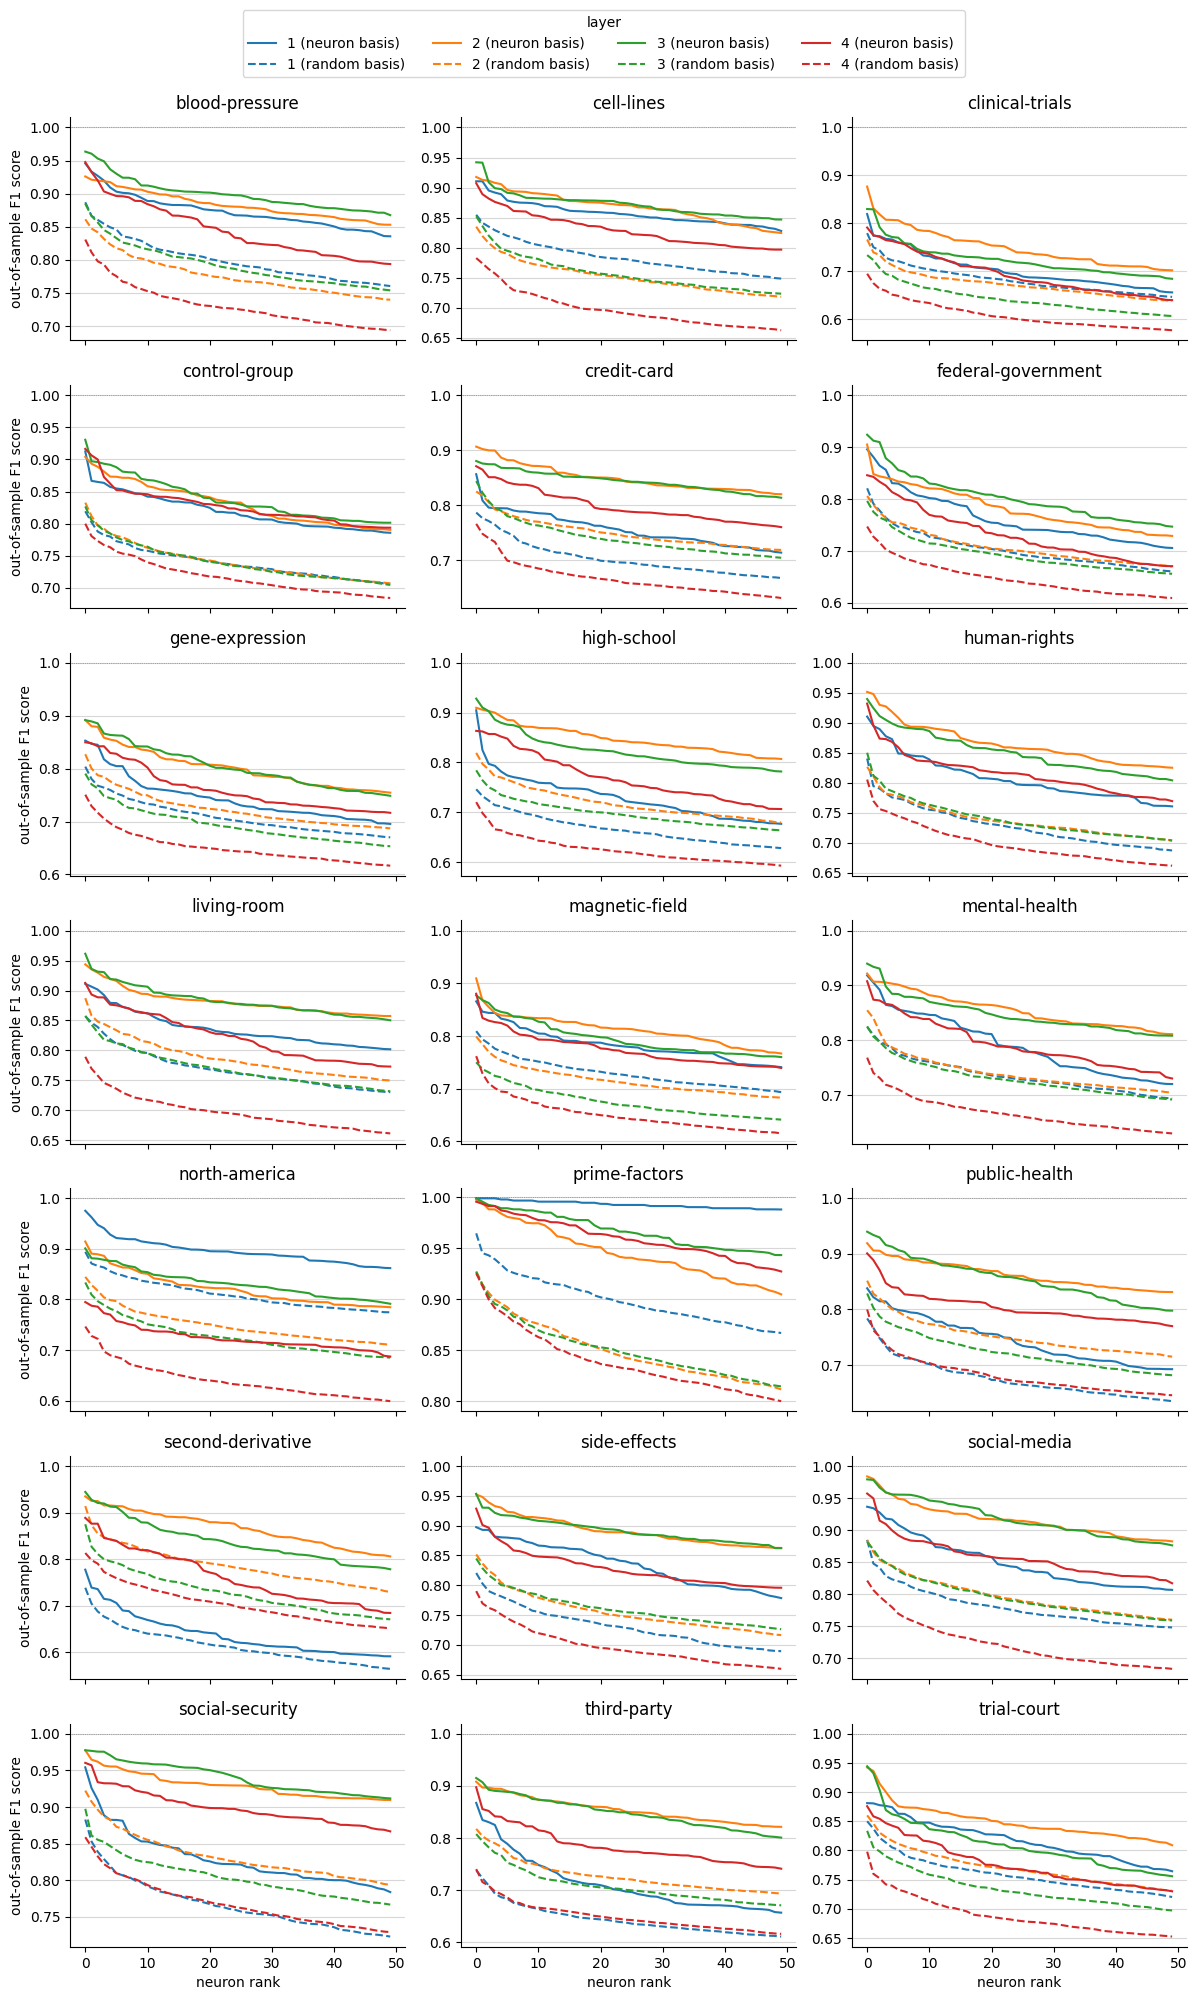

In [121]:
monosemantic_results_df = rdf
metric = 'test_f1_score'

layers = [1, 2, 3, 4]
default_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
upto_rank = 50

features = monosemantic_results_df.index.get_level_values('feature').unique().values
#layers = sorted(monosemantic_results_df.index.get_level_values('layer').unique())
n_rows = math.ceil(len(features) / 3)
fig, axs = plt.subplots(n_rows, 3, figsize=(12, 2.75 * n_rows), sharex=True, sharey=False)
for ix, f in enumerate(features):
    for l in layers:
        ax = axs[ix // 3, ix % 3]
        sub_df = monosemantic_results_df.query('feature==@f and layer==@l')
        neuron_prs = np.sort(sub_df[metric].values)[::-1][:upto_rank]
        ax.plot(neuron_prs, label=f'{l} (neuron basis)', color=default_colors[l-1])
        sub_baseline_df = avg_baseline.query('feature==@f and layer==@l')
        ax.plot(sub_baseline_df.values[:upto_rank], label=f'{l} (random basis)', color=default_colors[l-1], linestyle='dashed')

    ax.set_title(f)
    # dotted black horizontal line at 1.0
    ax.axhline(1.0, color='black', linestyle='dotted', alpha=0.5, linewidth=0.5)
    if ix % 3 == 0:
        ax.set_ylabel(metric)
    if ix >= len(features) - 3:
        ax.set_xlabel('neuron rank')

# turn off top and right splines
for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #turn on grid
    ax.grid(True, axis='y', alpha=0.5)

for i in range(n_rows):
    axs[i, 0].set_ylabel('out-of-sample F1 score')

# add legend to top of plot with y buffer
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, title='layer', bbox_to_anchor=(0.5, 1.04))

plt.tight_layout()

plt.savefig('figures/neuron_basis_alignment.png', bbox_inches='tight')

In [50]:
avg_baseline

feature         layer  neuron_rank
blood-pressure  0      1.0            0.515530
                       2.0            0.513961
                       3.0            0.512348
                       4.0            0.512060
                       5.0            0.510801
                                        ...   
trial-court     15     96.0           0.403278
                       97.0           0.401831
                       98.0           0.397823
                       99.0           0.392137
                       100.0          0.383545
Name: test_f1_score, Length: 33600, dtype: float64

In [126]:
results_dir = 'results'
experiment_name = 'compound_superposition_final'
model_name = 'pythia-1b'
dataset_name = 'compound_words.pyth.24.-1'
inner_loop = 'telescopic_sparsity_sweep'
PYTHIA_MODELS=['pythia-70m', 'pythia-160m', 'pythia-410m', 'pythia-1b', 'pythia-1.4b', 'pythia-2.8b', 'pythia-6.9b']

sparsity_sweep_results = {}
random_baseline_results = {}
for model in PYTHIA_MODELS:
    telescopic_probing_results, metadata = load_probing_experiment_results(results_dir, experiment_name, model, dataset_name, 'telescopic_sparsity_sweep', uncollapse_features=True)
    baseline_probing_results, metadata = load_probing_experiment_results(results_dir, experiment_name, model, dataset_name, 'rotation_baseline_dxd', uncollapse_features=True)
    sparsity_sweep_results[model] = telescopic_probing_results
    random_baseline_results[model] = baseline_probing_results


In [127]:
sparsity_rdict = {}
for k1, v1 in sparsity_sweep_results.items():
    for k2, v2 in v1.items():
        for k3, v3 in v2.items():
            sparsity_rdict[(k1, ) + k2 + (k3, )] = v3

baseline_rdict = {}
for k1, v1 in random_baseline_results.items():
    for k2, v2 in v1.items():
        for k3, v3 in v2.items():
            for k4, v4 in v3.items():
                baseline_rdict[(k1, ) + k2 + (k3, k4)] = v4

In [128]:
metric = 'test_log_loss'

srdf = pd.DataFrame(sparsity_rdict).T
srdf.index.names = ['model', 'feature', 'layer', 'agg', 'loc', 'k']
top_df = srdf.query('model == "pythia-1b"').sort_values(metric, ascending=False).groupby(['model', 'layer', 'feature', 'k']).head(1)
brdf = pd.DataFrame(baseline_rdict).T
brdf.index.names = ['model', 'feature', 'layer', 'agg', 'loc', 'trial', 'k']
brdf = brdf.query('model == "pythia-1b"').groupby(['model', 'feature', 'layer', 'agg', 'loc', 'k'])[['test_f1_score', 'test_mcc', 'test_log_loss', 'elapsed_time', 'max_iter']].mean()
top_baseline_df = brdf.sort_values(metric, ascending=False).groupby(['model', 'layer', 'feature', 'k']).head(1)

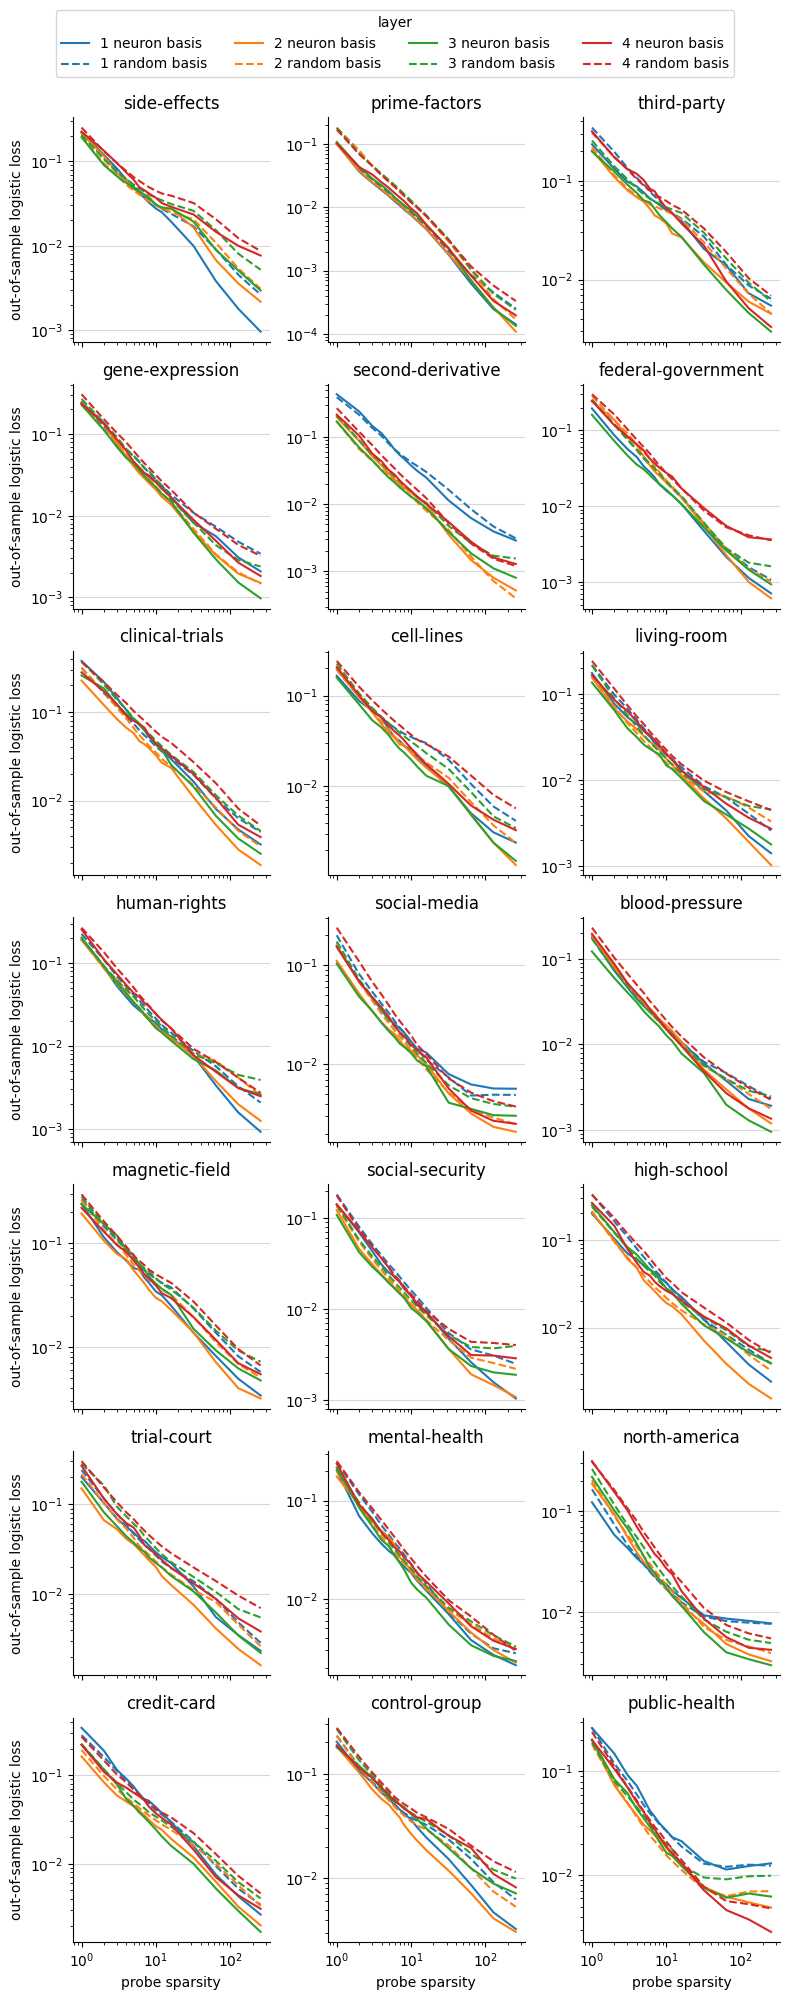

In [140]:

layers = [1, 2, 3, 4]
default_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
upto_rank = 50
max_k = 256

features = top_df.index.get_level_values('feature').unique().values
#layers = sorted(monosemantic_results_df.index.get_level_values('layer').unique())
n_rows = math.ceil(len(features) / 3)
fig, axs = plt.subplots(n_rows, 3, figsize=(8, 2.75 * n_rows), sharex=True, sharey=False)
for ix, f in enumerate(features):
    for l in layers:
        ax = axs[ix // 3, ix % 3]
        sub_df = top_df.query('feature==@f and layer==@l and k<=@max_k').sort_index()
        ax.plot(sub_df.index.get_level_values('k'), sub_df[metric].values, label=f'{l} neuron basis', color=default_colors[l-1])
        sub_baseline_df = top_baseline_df.query('feature==@f and layer==@l and k<=@max_k').sort_index()
        ax.plot(sub_baseline_df.index.get_level_values('k'), sub_baseline_df[metric].values, label=f'{l} random basis', color=default_colors[l-1], linestyle='dashed')

    ax.set_title(f)
    # dotted black horizontal line at 1.0
    #ax.axhline(1.0, color='black', linestyle='dotted', alpha=0.5, linewidth=0.5)
    if ix % 3 == 0:
        ax.set_ylabel(metric)
    if ix >= len(features) - 3:
        ax.set_xlabel('probe sparsity')

# turn off top and right splines
for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #turn on grid
    ax.grid(True, axis='y', alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')

for i in range(n_rows):
    axs[i, 0].set_ylabel('out-of-sample logistic loss')

# add legend to top of plot with y buffer
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, title='layer', bbox_to_anchor=(0.5, 1.04))

plt.tight_layout()

plt.savefig('figures/basis_sparsity_sweep.png', bbox_inches='tight')

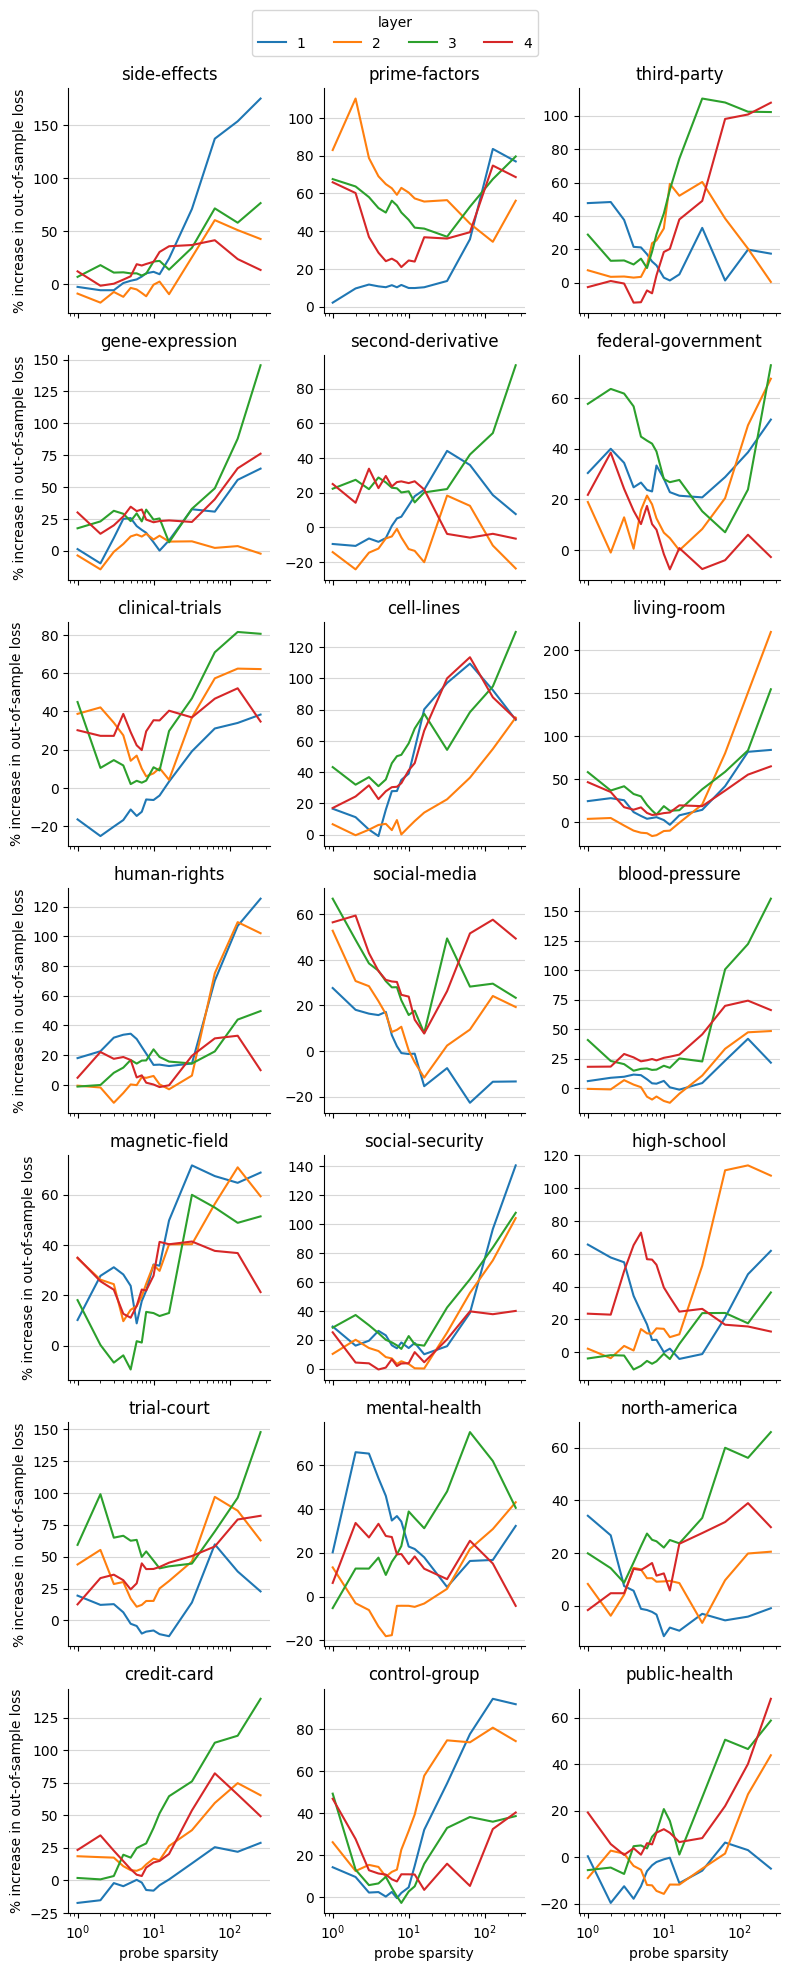

In [141]:

layers = [1, 2, 3, 4]
default_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
upto_rank = 50
max_k = 256
metric = 'test_log_loss'

features = top_df.index.get_level_values('feature').unique().values
#layers = sorted(monosemantic_results_df.index.get_level_values('layer').unique())
n_rows = math.ceil(len(features) / 3)
fig, axs = plt.subplots(n_rows, 3, figsize=(8, 2.75 * n_rows), sharex=True, sharey=False)
for ix, f in enumerate(features):
    for l in layers:
        ax = axs[ix // 3, ix % 3]
        sub_df = top_df.query('feature==@f and layer==@l and k<=@max_k').sort_index()
        sub_baseline_df = top_baseline_df.query('feature==@f and layer==@l and k<=@max_k').sort_index()
        ratio =  (sub_baseline_df[metric].values - sub_df[metric].values) * 100 / sub_df[metric].values
        ax.plot(sub_df.index.get_level_values('k'), ratio, label=l, color=default_colors[l-1])

        # ax.plot(sub_baseline_df.index.get_level_values('k'), sub_baseline_df[metric].values, label=f'{l} random basis', color=default_colors[l-1], linestyle='dashed')

    ax.set_title(f)
    # dotted black horizontal line at 1.0
    #ax.axhline(1.0, color='black', linestyle='dotted', alpha=0.5, linewidth=0.5)
    if ix % 3 == 0:
        ax.set_ylabel(metric)
    if ix >= len(features) - 3:
        ax.set_xlabel('probe sparsity')

# turn off top and right splines
for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #turn on grid
    ax.grid(True, axis='y', alpha=0.5)
    ax.set_xscale('log')
    #ax.set_yscale('log')

for i in range(n_rows):
    axs[i, 0].set_ylabel('% increase in out-of-sample loss')

# add legend to top of plot with y buffer
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, title='layer', bbox_to_anchor=(0.5, 1.025))

plt.tight_layout()

plt.savefig('figures/basis_increase_sparsity_sweep.png', bbox_inches='tight')

In [134]:
ratio

array([-0.041930600124516694, 0.004196421691942305, 0.005002450872098695,
       0.009069786557035995, 0.0027795456721510336,
       -0.0012955423175713431, -0.0012931202945648233,
       -0.00021877446018313823, -0.0008583770298583445,
       0.0004277936219859355, -0.0006433168191582113,
       0.0004314949769334912, 0.00021597972472992168,
       -0.0010787337006108117, -0.0010787337006108117], dtype=object)

In [130]:
metric = 'test_f1_score'

srdf = pd.DataFrame(sparsity_rdict).T
srdf.index.names = ['model', 'feature', 'layer', 'agg', 'loc', 'k']
top_df = srdf.query('model == "pythia-1b"').sort_values(metric, ascending=False).groupby(['model', 'layer', 'feature', 'k']).head(1)
brdf = pd.DataFrame(baseline_rdict).T
brdf.index.names = ['model', 'feature', 'layer', 'agg', 'loc', 'trial', 'k']
brdf = brdf.query('model == "pythia-1b"').groupby(['model', 'feature', 'layer', 'agg', 'loc', 'k'])[['test_f1_score', 'test_mcc', 'test_log_loss', 'elapsed_time', 'max_iter']].mean()
top_baseline_df = brdf.sort_values(metric, ascending=False).groupby(['model', 'layer', 'feature', 'k']).head(1)

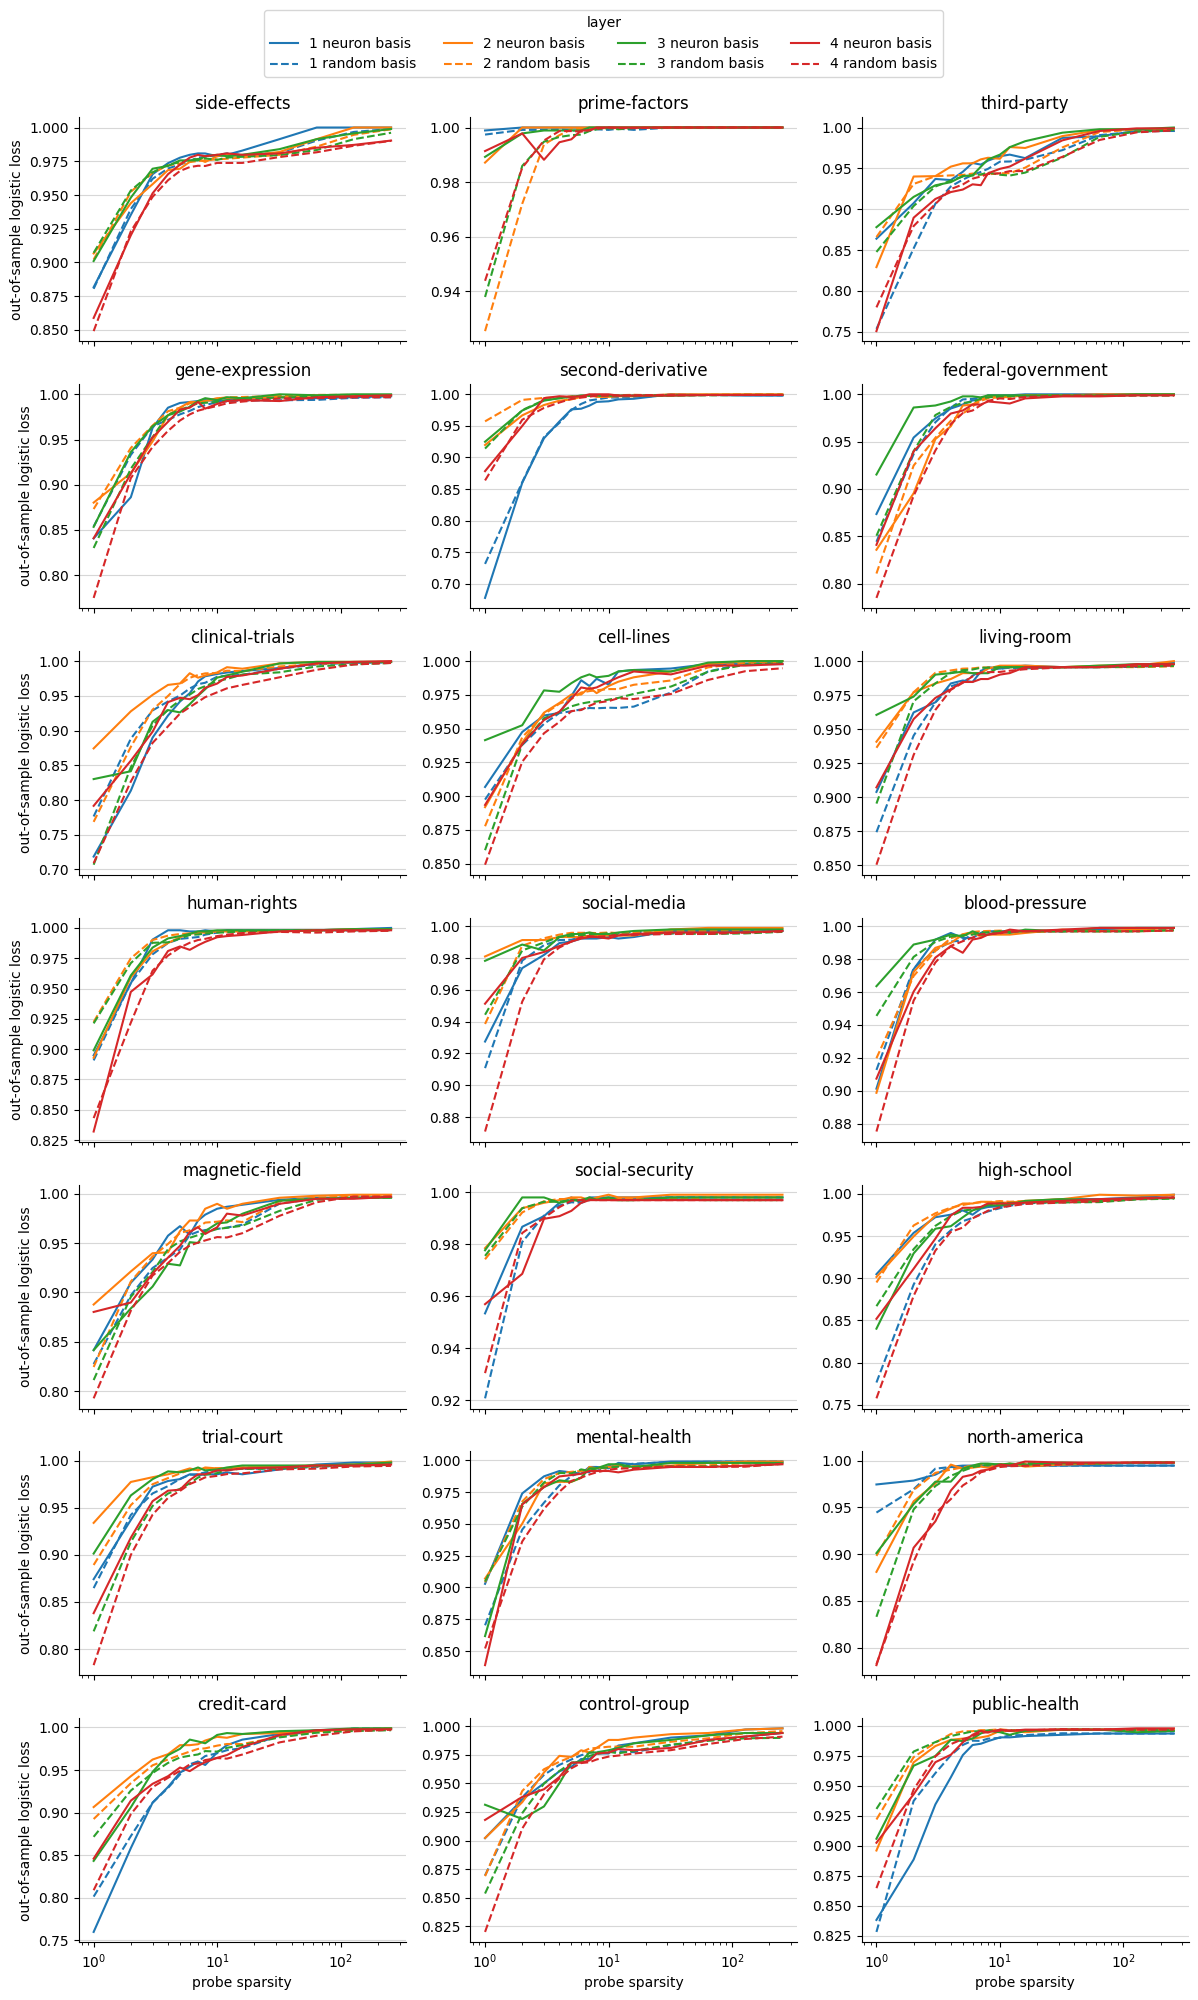

In [131]:

layers = [1, 2, 3, 4]
default_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
upto_rank = 50

features = top_df.index.get_level_values('feature').unique().values
#layers = sorted(monosemantic_results_df.index.get_level_values('layer').unique())
n_rows = math.ceil(len(features) / 3)
fig, axs = plt.subplots(n_rows, 3, figsize=(12, 2.75 * n_rows), sharex=True, sharey=False)
for ix, f in enumerate(features):
    for l in layers:
        ax = axs[ix // 3, ix % 3]
        sub_df = top_df.query('feature==@f and layer==@l').sort_index()
        ax.plot(sub_df.index.get_level_values('k'), sub_df[metric].values, label=f'{l} neuron basis', color=default_colors[l-1])
        sub_baseline_df = top_baseline_df.query('feature==@f and layer==@l').sort_index()
        ax.plot(sub_baseline_df.index.get_level_values('k'), sub_baseline_df[metric].values, label=f'{l} random basis', color=default_colors[l-1], linestyle='dashed')

    ax.set_title(f)
    # dotted black horizontal line at 1.0
    #ax.axhline(1.0, color='black', linestyle='dotted', alpha=0.5, linewidth=0.5)
    if ix % 3 == 0:
        ax.set_ylabel(metric)
    if ix >= len(features) - 3:
        ax.set_xlabel('probe sparsity')

# turn off top and right splines
for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #turn on grid
    ax.grid(True, axis='y', alpha=0.5)
    ax.set_xscale('log')

for i in range(n_rows):
    axs[i, 0].set_ylabel('out-of-sample logistic loss')

# add legend to top of plot with y buffer
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, title='layer', bbox_to_anchor=(0.5, 1.04))

plt.tight_layout()

In [132]:
plot_top_neurons(brdf.query('trial==1'), metric='test_mcc')

UndefinedVariableError: name 'trial' is not defined

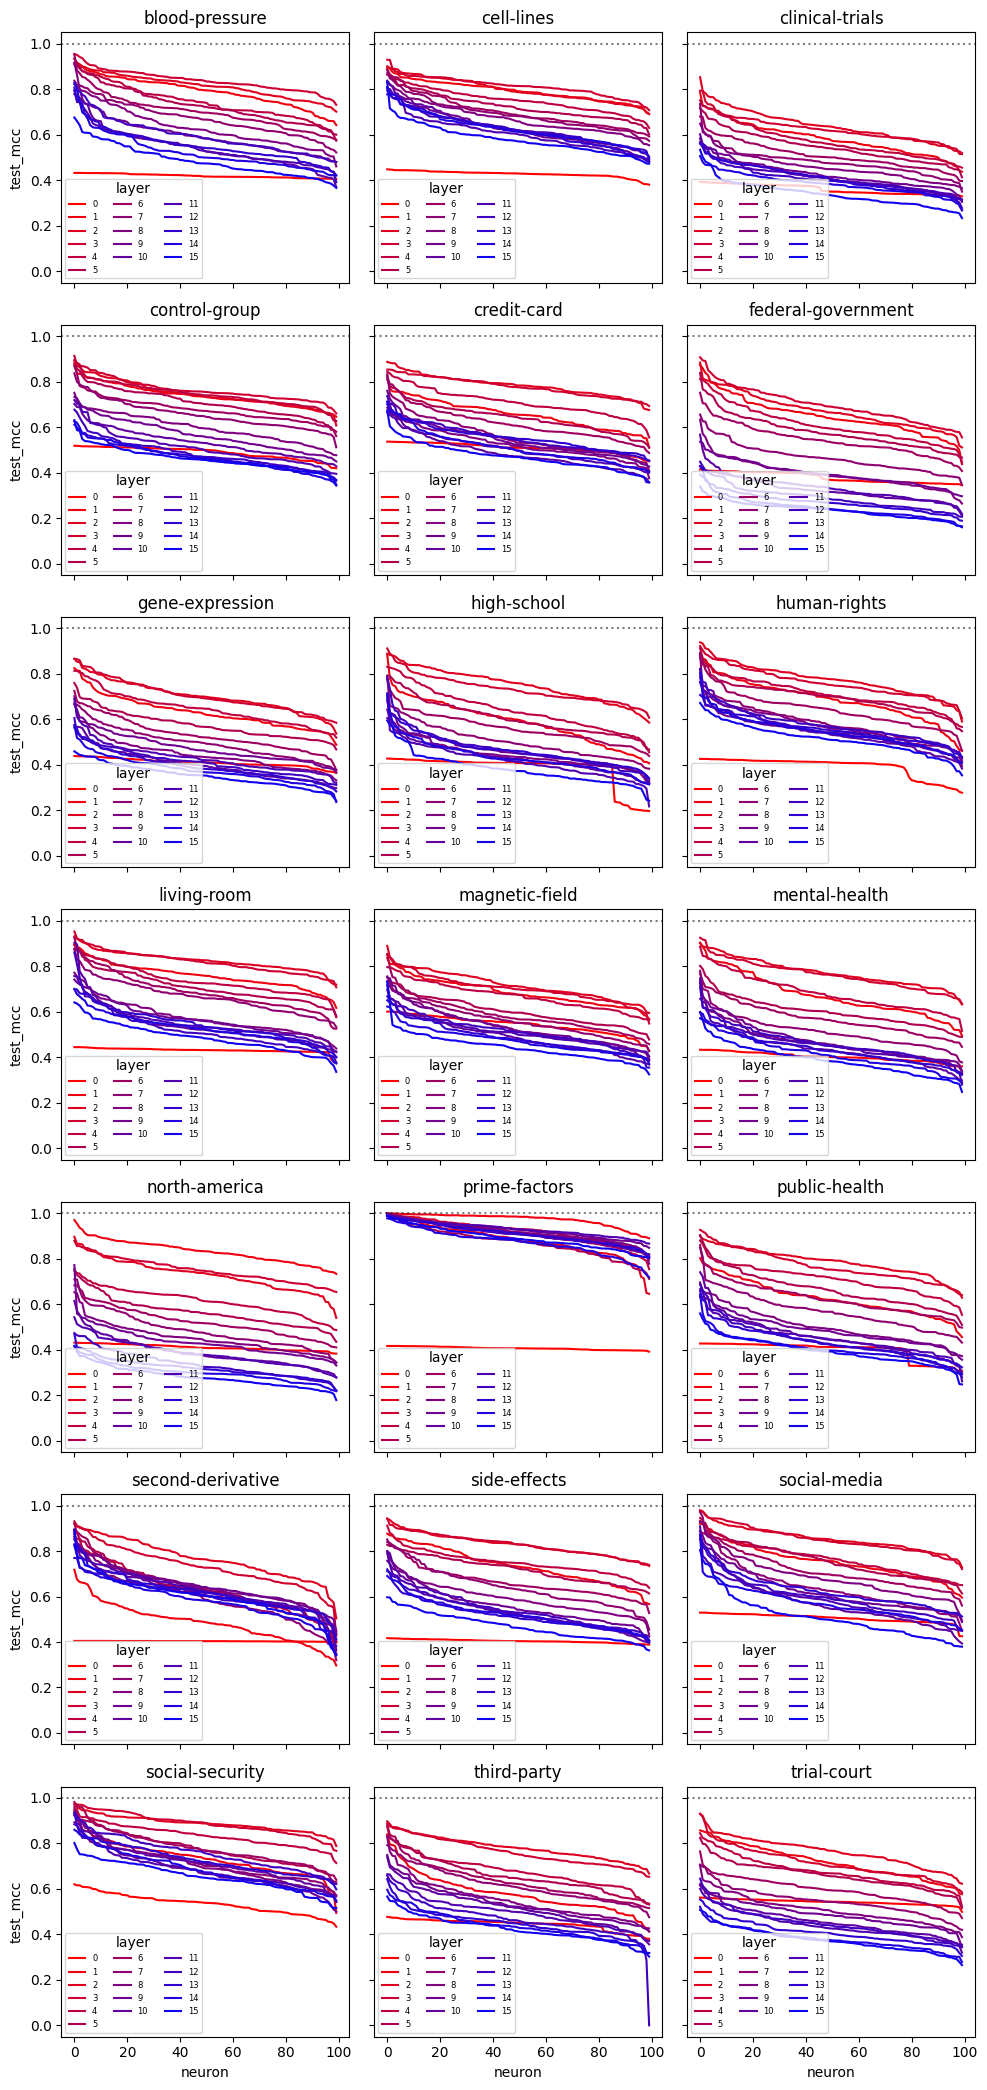

In [33]:
plot_top_neurons(rdf, metric='test_mcc')